# Construction of FFNN 
Here, we build a Feedforward Neural Network (FFNN) designed to predict the design space given a desired moment capacity. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import save_model

## Loading the training space and visualizing it (4D data).
1. 3D grid with color map representing mometn capacity


0.10992166766770627
1223.4142003195038


C:\Users\adelpasand\AppData\Local\Temp\ipykernel_25748\321668278.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


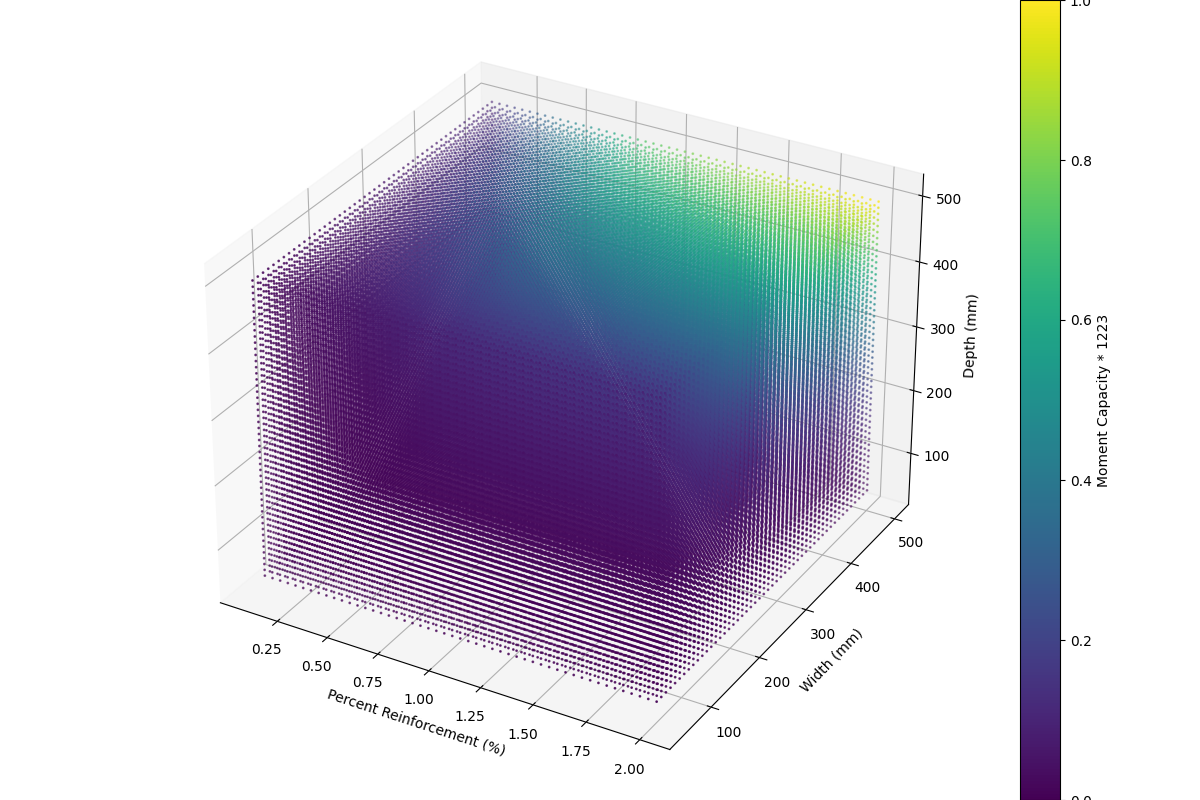

In [21]:

Design_space = np.load('Design_space.npy')
moment_capacity = np.load('Mu.npy')
p_values = Design_space[:, 0]
b_values = Design_space[:, 1]
d_values = Design_space[:, 2]


# Normalize moment capacity values to the range [0, 1]
min_output = np.min(moment_capacity)
max_output = np.max(moment_capacity)
normalized_outputs = (moment_capacity - min_output) / (max_output - min_output)
print(min_output)
print(max_output)

# Plot 4D data using color encoding
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig) 

# Define color map
cmap = plt.get_cmap('viridis')

sc = ax.scatter(p_values, b_values, d_values, c=normalized_outputs, cmap=cmap, marker='o', s=1)
cbar = plt.colorbar(sc)
cbar.set_label('Moment Capacity * {}'.format(int(max_output)))

ax.set_xlabel('Percent Reinforcement (%)')
ax.set_ylabel('Width (mm)')
ax.set_zlabel('Depth (mm)')
ax.set_title('4D Plot with Color Encoding (Normalized Moment Capacity)')

plt.show()


Classifying reinforcement ratio with distinct colors and plotting the 3D data, aiming to discern patterns for future utilization of Physics-Informed Neural Networks (PINNs).

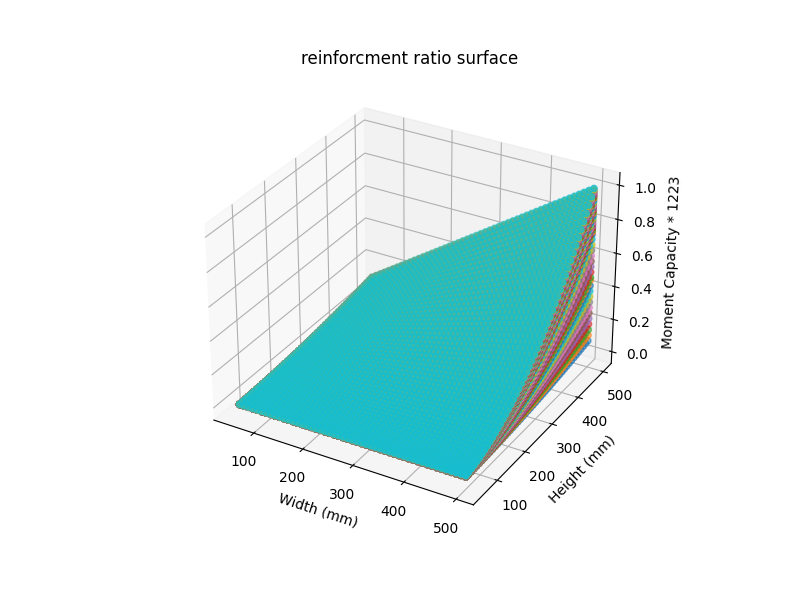

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget 


# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


# Loop through unique fixed values
index = 0
for i in np.unique(Design_space[:, 0]):
    subset = Design_space[Design_space[:, 0] == i]
    z_values = normalized_outputs[Design_space[:, 0] == i]
    ax.scatter(subset[:, 1], subset[:, 2], z_values, label=f"Set {int(i)}")
    index += 1
    # if index == 10:
    #     break

ax.set_xlabel('Width (mm)')
ax.set_ylabel('Height (mm)')
ax.set_zlabel('Moment Capacity * {}'.format(int(max_output)))
ax.set_title('reinforcment ratio surface')



plt.show()


## Defining the neural network model with arbitrary hyperparameters (64,32) and ReLU activation function.

In [6]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),  # Input layer with 1 neuron
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(3)  # Output layer with 3 neurons
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Using mean squared error loss and Adam optimizer

## Training the FFNN, plotting Model Training Loss curve and saving Trained Model

C:\Users\adelpasand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


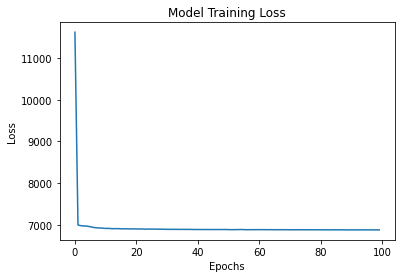

In [63]:
# Train the model
history = model.fit(moment_capacity, Design_space, epochs=100, batch_size=16, verbose=0)
model.save('trained_model.h5')
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Testing the trained FFNN on the nodes within the training space.

In [7]:
from tensorflow.keras.models import load_model
model = load_model('trained_model.h5')

# picking 7 row from the data
step_size = Design_space.shape[0]//7

# selected actual design parameters associated with moment capacity .
selected_actual_params= Design_space[::step_size]
moment_capacity_test = moment_capacity[::step_size] # New input data for prediction

# print(selected_actual_params)
# print(moment_capacity_test)

# Predict on new data
moment_capacity_test = moment_capacity_test

Designe_pred = model.predict(moment_capacity_test)

# print(Designe_pred)




[[1.00000000e-01 5.00000000e+01 5.00000000e+01]
 [3.71428571e-01 1.14285714e+02 1.14285714e+02]
 [6.42857143e-01 1.78571429e+02 1.78571429e+02]
 [9.14285714e-01 2.42857143e+02 2.42857143e+02]
 [1.18571429e+00 3.07142857e+02 3.07142857e+02]
 [1.45714286e+00 3.71428571e+02 3.71428571e+02]
 [1.72857143e+00 4.35714286e+02 4.35714286e+02]
 [2.00000000e+00 5.00000000e+02 5.00000000e+02]]
[1.09921668e-01 4.77666944e+00 3.00923311e+01 1.04507896e+02
 2.33939748e+02 4.47186302e+02 7.68531035e+02 1.22341420e+03]
1/1 [==============================] - 0s 114ms/step
[[ -0.5318531  71.475525   56.026104 ]
 [  0.6872051 196.89696    93.32229  ]
 [  0.8866472 238.20511   194.36649  ]
 [  1.0295744 255.38591   295.08188  ]
 [  1.1955783 298.08533   350.0674   ]
 [  1.3336463 349.4556    402.725    ]
 [  1.4385333 411.80435   447.9268   ]
 [  1.7270937 500.12564   511.7654   ]]


## Visualizing the accuracy of FFNN predictions.

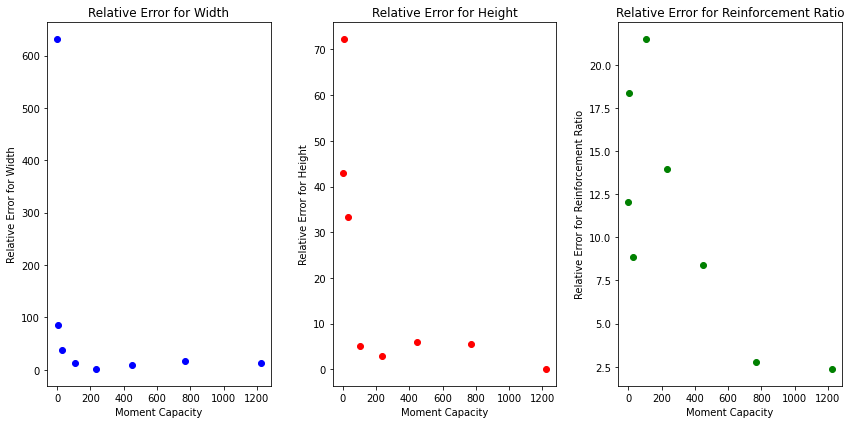

In [8]:

# Calculate the absolute errors for each predicted parameter
errors_width = 100*np.abs(selected_actual_params[:, 0] - Designe_pred[:, 0])/selected_actual_params[:, 0]
errors_height = 100*np.abs(selected_actual_params[:, 1] - Designe_pred[:, 1])/selected_actual_params[:, 1]
errors_reinforcement = 100*np.abs(selected_actual_params[:, 2] - Designe_pred[:, 2])/selected_actual_params[:, 2]

# Plot the absolute errors for each predicted parameter
plt.figure(figsize=(12, 6))

# Width
plt.subplot(1, 3, 1)
plt.scatter(moment_capacity_test, errors_width, color='blue')
plt.xlabel('Moment Capacity')
plt.ylabel('Relative Error for Width')
plt.title('Relative Error for Width')

# Height
plt.subplot(1, 3, 2)
plt.scatter(moment_capacity_test, errors_height, color='red')
plt.xlabel('Moment Capacity')
plt.ylabel('Relative Error for Height')
plt.title('Relative Error for Height')

# Reinforcement ratio
plt.subplot(1, 3, 3)
plt.scatter(moment_capacity_test, errors_reinforcement, color='green')
plt.xlabel('Moment Capacity')
plt.ylabel('Relative Error for Reinforcement Ratio')
plt.title('Relative Error for Reinforcement Ratio')

plt.tight_layout()
plt.show()
